In [32]:
from __future__ import print_function, division
import thinkbayes
import thinkplot

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, halfnorm, triang 
import scipy.interpolate as interpolate

from math import sqrt

In [2]:
class Invest(thinkbayes.Suite):
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        hypo: integer value of x, the probability of heads (0-100)
        data: string 'H' or 'T'
        """
        p = hypo / 100.0
        if data == 'H':
            return p
        else:
            return 1-p


############################################# PLOTTING FUNCTIONS
def plot_aggregator(data_h, data_w, gamma, sigma):
    # evenly sampled time at 1 intervals
    t = np.arange(1, data_h.shape[0]+1, 1)
    plt.plot(t,data_h.mean(1), 'r', linewidth=5.0, label='Herding')     
    plt.plot(t,data_w.mean(1), 'b', linewidth=5.0, label='Wisdom')  # row axis is 1; column axis is 0. http://docs.scipy.org/doc/numpy/reference/generated/numpy.matrix.mean.html#numpy.matrix.mean
    theta_down= gamma-sigma
    theta_up= gamma+sigma
    plt.axhline(y=theta_down)
    plt.axhline(y=theta_up)
    plt.ylabel('The evolution of beliefts')
    plt.ylim((0,100))
    plt.legend()
    plt.show()

def plotme_one_graph_w_confidence_interval(data_h, data_w, theta_down, theta_up):
    # evenly sampled time at 1 intervals
    t = np.arange(1, data_h.shape[0]+1, 1)
    plt.plot(t,data_h[:,0], 'r--')
    plt.plot(t,data_h[:,1], 'r--') 
    herding_, =plt.plot(t,data_h[:,2], 'r', linewidth=5.0, label='Herding')     
    plt.plot(t,data_w[:,0], 'b--')
    plt.plot(t,data_w[:,1], 'b--') 
    wisdom_ = plt.plot(t,data_w[:,2], 'b', linewidth=5.0, label='Wisdom')
    plt.axhline(y=theta_down)
    plt.axhline(y=theta_up)
    plt.ylabel('The evolution of beliefts')
    plt.ylim((0,100))
    plt.legend()
    plt.show()


########################
def AverageLikelihood(suite, data):
    total = 0
    for hypo, prob in suite.Items():
        like = suite.Likelihood(data, hypo)
        total += prob * like
    return total


def analyze(suite, evidence, theta_down=50, theta_up=75,herding='herding'):
    list_=[]
    actual=[]
    if herding=='herding':
        for outcome in evidence:
            #theta_start = AverageLikelihood(suite, outcome)
            theta_start = suite.MaximumLikelihood()
            ci= suite.CredibleInterval(90)
            list_.append([ci[0],ci[1], theta_start])
            if theta_start>theta_down and theta_start<theta_up:
                suite.Update(outcome)
                actual.append(outcome)
                #print("mid")
            elif theta_start>=theta_up:
                suite.Update('H')
                actual.append('H')
                #print("H")
            elif theta_start<=theta_down:
                suite.Update('T')
                actual.append('T')
                #print("T")
    elif herding=='wisdom':
        for outcome in evidence:
            theta_start = suite.MaximumLikelihood()
            ci= suite.CredibleInterval(90)
            list_.append([ci[0],ci[1], theta_start])
            suite.Update(outcome)
            actual.append(outcome)
    return list_, suite, actual


################################
'''
def triangle_prior(mode):
    suite = Invest()
    for x in range(0, mode+1):
        suite.Set(x, x)
    for x in range(mode+1, 101):
        suite.Set(x, mode/(100-mode)*(100-x))
    suite.Normalize()
    return suite
'''
def triangle_pior(mode):
    suite = Invest()
    for x in range(0,101):
        suite.Set(x, triang.pdf(x,c=mode/100.0, loc=0, scale=100))
    suite.Normalize()
    return suite



def normal_prior(mean, sd):
    suite = Invest()
    for x in range(0,101):
        suite.Set(x, norm.pdf(x, loc=mean, scale=sd))
    suite.Normalize()
    return suite

def ushaped_prior(mean_left, sd_left, mean_right, sd_right):
    suite = Invest()
    left_side= halfnorm.rvs(loc=mean_left, scale=sd_left, size=1000)
    ##
    right_side = halfnorm.rvs(loc=mean_right, scale=sd_right, size=1000)
    a = np.empty(right_side.size)
    a.fill(100.0)
    shift_right=-1*right_side + a
    data= np.hstack((left_side,shift_right, np.linspace(0, 100.0, num=1000)))
    hist, bin_edges = np.histogram(data, bins = np.arange(102), density=True)
    for x in range(0,101):
        suite.Set(x, hist[x])
    suite.Normalize()
    return suite

    

###################################
def evidence_fun(random_numbers, threshold_quality=75 ):
    evidence=''
    for item in random_numbers:
        if item>=threshold_quality: 
            evidence +='H'
        else:
            evidence +='T'
    return evidence    

def gen_evidence_normal(mean, sd, size=100, threshold_quality=75):
    r = norm.rvs(loc=mean, scale=sd, size=size)
    return evidence_fun(r, threshold_quality = threshold_quality)

def gen_evidence_ushaped(mean_left, sd_left, mean_right, sd_right, size=100, threshold_quality=75):
    left_side= halfnorm.rvs(loc=mean_left, scale=sd_left, size=size)
    ##
    right_side = halfnorm.rvs(loc=mean_right, scale=sd_right, size=size)
    a = np.empty(right_side.size)
    a.fill(100.0)
    shift_right=-1*right_side + a
    data= np.hstack((left_side,shift_right, np.linspace(0, 100.0, num=size)))
    r= inverse_transform_sampling(data,n_bins=100, n_samples=size  ) #project quality varies from 0 to 100.
    return evidence_fun(r, threshold_quality = threshold_quality)

def gen_evidence_triangle(mode, size=100, threshold_quality=75):
    r= triang.rvs(c = mode/100.0, loc=0, scale  =100, size=size) #project quality varies from 0 to 100.
    return evidence_fun(r, threshold_quality = threshold_quality)



#http://www.nehalemlabs.net/prototype/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/   
def inverse_transform_sampling(data, n_bins=40, n_samples=1000):
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    return inv_cdf(r)



In [34]:
def result(method, steps=100, threshold_quality=75, gamma=50, sigma=25):
    # which case is the method
    if method['private_belief_distribution'] == 'normal':
        mean = method['mean']
        sd = method['sd']
        suite_h = normal_prior(mean=mean, sd=sd)
        suite_w = normal_prior(mean=mean, sd=sd)
        #suite_prior = normal_prior(mean=mean, sd=sd)
        evidence = gen_evidence_normal(mean=mean, sd=sd, size=steps, threshold_quality=threshold_quality)
    elif method['private_belief_distribution'] == 'ushaped':
        mean_left = method['mean_left']
        sd_left= method['sd_left']
        mean_right = method['mean_right']
        sd_right= method['sd_right']
        if method['initial_prior']=='normal':
            suite_h = normal_prior(mean=50, sd=(sd_left+sd_right)/2)
            suite_w = normal_prior(mean=50, sd=(sd_left+sd_right)/2)           
        else:
            suite_h = ushaped_prior(mean_left, sd_left, mean_right, sd_right)
            suite_w = ushaped_prior(mean_left, sd_left, mean_right, sd_right)
        evidence = gen_evidence_ushaped(mean_left, sd_left, mean_right, sd_right ,size=steps,threshold_quality= threshold_quality)
    elif method['private_belief_distribution'] == 'triangle':
        mode= method['mode']
        suite_h = triangle_pior(mode = mode)
        suite_w = triangle_pior(mode = mode)
        evidence = gen_evidence_triangle(mode = mode , size= steps, threshold_quality= threshold_quality)
    else:
        suite_h = Invest(range(0, 101))
        suite_w = Invest(range(0, 101))
        evidence = gen_evidence_uniform(size=steps,threshold_quality= threshold_quality)      
    theta_down= gamma-sigma
    theta_up= gamma+sigma
    list_info_h, suite_h, actual_h= analyze(suite_h, evidence, theta_down= theta_down, theta_up= theta_up,  herding='herding')
    list_info_w, suite_w, actual_w= analyze(suite_w, evidence,  herding='wisdom')
    # plotme_one_graph_w_confidence_interval(np.matrix(list_info_h) , np.matrix(list_info_w), theta_down, theta_up )
    return np.matrix(list_info_h), np.matrix(list_info_w)
    

def replicate_results(method, steps=100, threshold_quality=75, gamma=50, sigma=25, repeat=100):
    aggregator_h = np.matrix(np.zeros(shape=(steps,repeat)))
    aggregator_w = np.matrix(np.zeros(shape=(steps,repeat)))
    for t in range(repeat):
        data_h, data_w=result(method= method, steps=steps, threshold_quality=threshold_quality, gamma=gamma, sigma=sigma )
        aggregator_h[:,t]= data_h[:,2]
        aggregator_w[:,t]= data_w[:,2]
    return plot_aggregator(aggregator_h, aggregator_w, gamma, sigma)


<h1 align="center">results</h1> 



<h3 align="center">Mean of private beliefs</h3>
##### Prior success increases the mean of backer's private beliefs (drawn from a normal distribution with equal variance) about the unobserved quality in both (a) herding and (b) wisdom of crowd. 

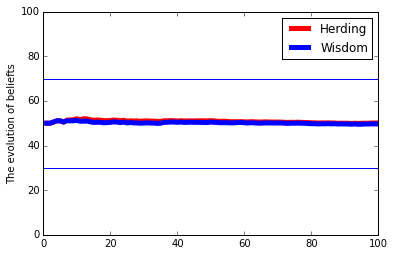

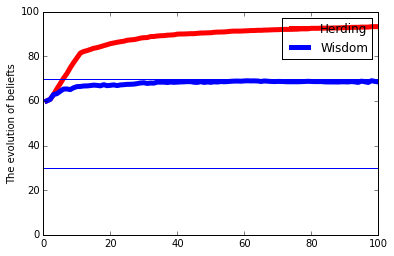

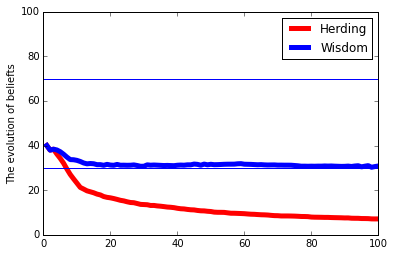

In [4]:
# (gamma - sigma, gamma + sigma) is the complement of cascade set.
replicate_results(method={'private_belief_distribution': 'normal', 'mean': 50, 'sd': 20}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'normal', 'mean': 60, 'sd': 20}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'normal', 'mean': 40, 'sd': 20}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)


<h3 align="center">Standard deviation of private belief</h3> 

####It seems that increase of the precision of the signal of private belief of an individual backer has dual effect: the effect depends on the mean of private belief (correlated positively with prior success)

##### (a) Prior success (higher mean) coupled with (b) higher precision of the signal of private belief of an individual backer) seems to delay the start of the herding point towards full-funding.

##### (a) Prior failure (lower mean) coupled with (b) higher precision of the signal of private belief of an individual backer seem to accelerate the start of the herding point towards full failure.

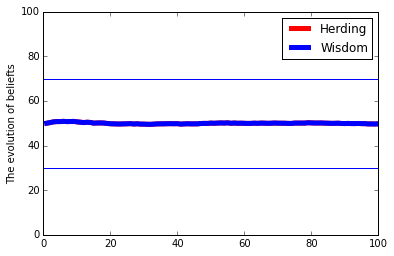

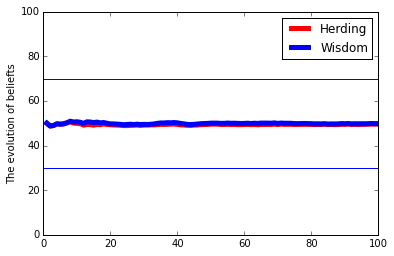

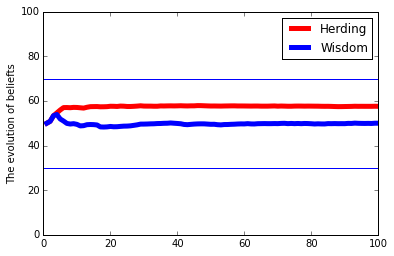

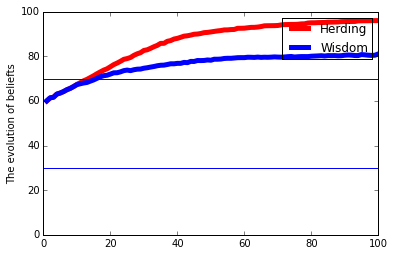

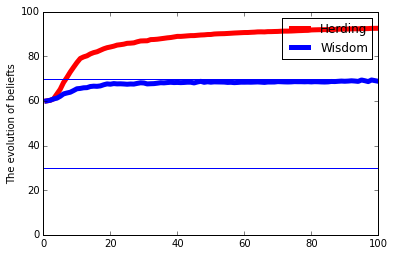

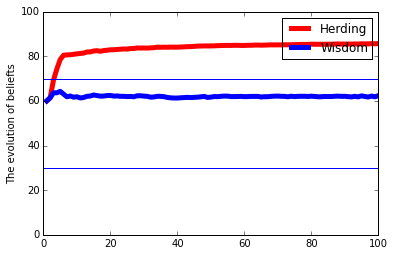

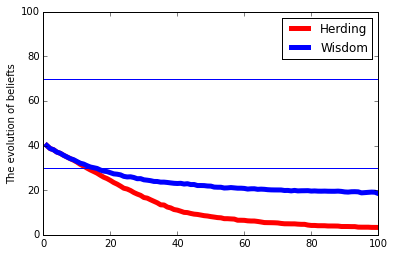

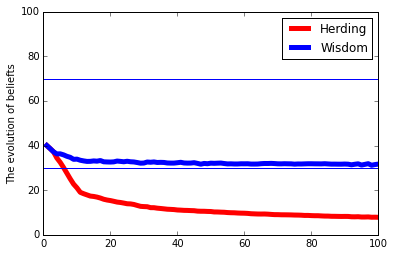

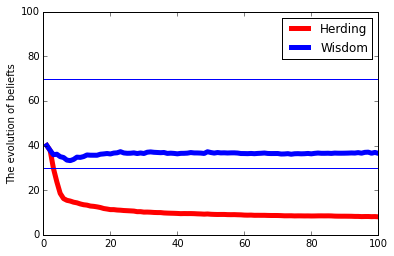

In [5]:
# change SD at different values of mean
#graphs are in order.
replicate_results(method={'private_belief_distribution': 'normal', 'mean': 50, 'sd': 10}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'normal', 'mean': 50, 'sd': 20}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'normal', 'mean': 50, 'sd': 30}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)


replicate_results(method={'private_belief_distribution': 'normal', 'mean': 60, 'sd': 10}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'normal', 'mean': 60, 'sd': 20}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'normal', 'mean': 60, 'sd': 30}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)


replicate_results(method={'private_belief_distribution': 'normal', 'mean': 40, 'sd': 10}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'normal', 'mean': 40, 'sd': 20}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'normal', 'mean': 40, 'sd': 30}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)



<h3 align="center"> Threshold quality to be investable for a backer (investment grade) </h3> 

##### Prior success lowers the threshold that a decision maker believes a project is investable (As the threshold quality decreases (i.e., backers require less demonstration of quality/effort for any given quality project), the chances of funding and herding towards full-funding increases).

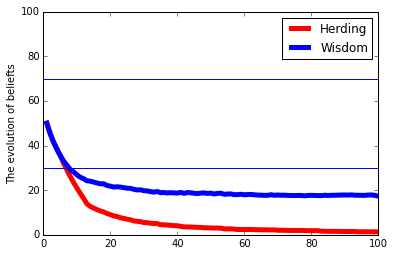

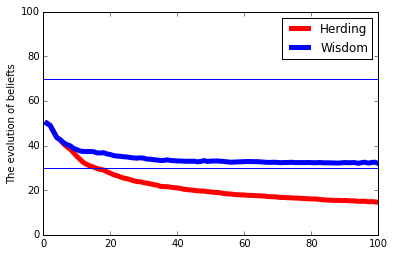

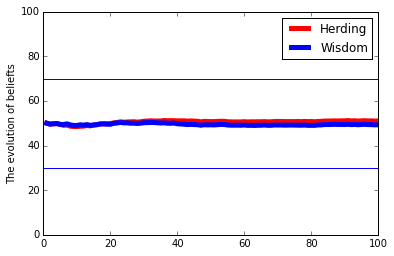

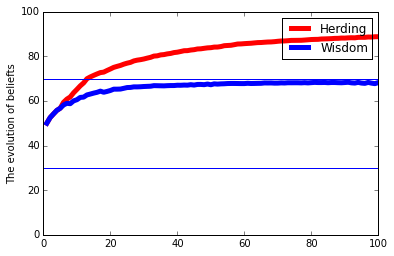

In [18]:
#change threshold_quality
replicate_results(method={'private_belief_distribution': 'normal', 'mean': 50, 'sd': 20}, steps=100, threshold_quality=70, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'normal', 'mean': 50, 'sd': 20}, steps=100, threshold_quality=60, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'normal', 'mean': 50, 'sd': 20}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'normal', 'mean': 50, 'sd': 20}, steps=100, threshold_quality=40, gamma=50, sigma=20, repeat=100)


<h3 align="center"> Investors with strong beliefs </h3> 


#### we change the distribution of all backer´s private beliefs into U-shaped (with left and right curves compsed of normal pdf). The U-shaped disribution is a mixture of two half-normal distributions: (A) the left half-normal distribution is at mean zero (and truncated from below at zero) and standard deviation called SD_left; (B) the right half-normal distribution has a mean at 100 (truncated from above at 100) with standard deviation called SD_right. The sum of the distributions goes from zero to 100 (the possible values on quality) and the probabalities represent the degree of belief in that quality for a given backer. 

#### I have two different initial priors (variable "initial_prior"): "itself" and "normal". "itself" has a distribution similar to the private belief of one individual backer (U-shaped). However, normal has a normal distribution with mean = 50 and standard deviation is the average of SD_right and SD_left. (this is intended to be similar to previous baselines. I am looking for better suggestions instead of averaging SDs? I could not find a closed formula to find SD of two half-normal distribution. maybe I should go for empirical one!) 
#######I just show that skwed INITIAL Priors coming from juxtuposition of two half-normal functions is a bad idea in the first three graphs. the posterior maximum likelihood already in the beginning has passed the herding thin blue lines. that is why I go with normal initial priors (mean = 50 and SD= average of SD_right and SD_left).


#### Looking at this exerise (thes graphs below and the one coming right after), my conlcusion is that investors with strong beliefs push towards herding only when they change the threshold of quality investable for other backers. (a) initial high-believers (those that have a strong signal on high quality (i.e. low right-side SD)), only are influential when they persuade other high-believers to invest by lowering their expectations of threshold quality. this ensues herding towards full funding. (b) initial low-believers (those that have a strong signal on low quality project (i.e., low left-side SD), only are infuential when they persuade other low-believers not to invest (by increasing their threshold of quality expectations). this ensues herding towards not funding.


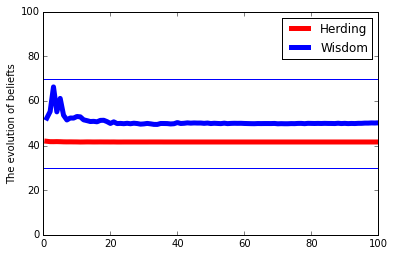

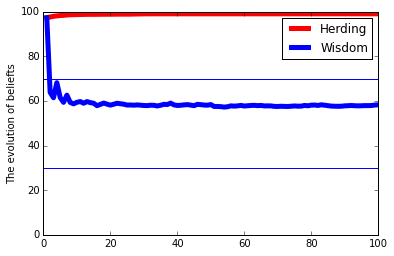

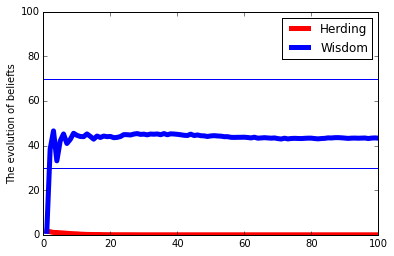

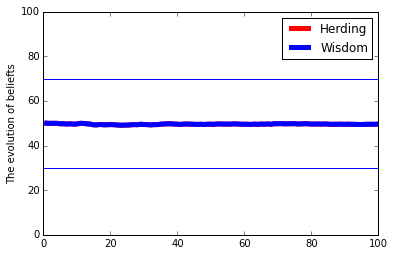

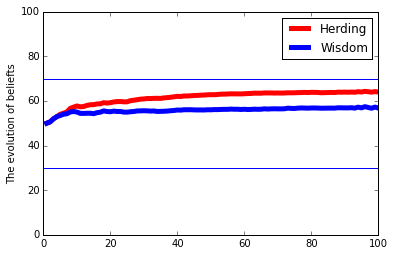

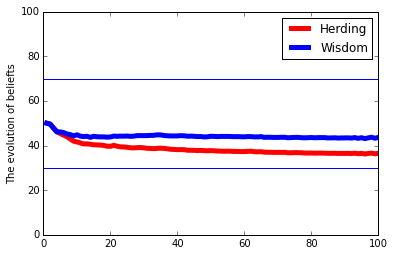

In [35]:
# change initial prior into "itslef": U-shaped at various values of SD_left and SD_right.
replicate_results(method={'private_belief_distribution': 'ushaped', 'mean_left': 0, 'sd_left': 10, 'mean_right': 0, 'sd_right': 10, 'initial_prior': 'itself'}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'ushaped', 'mean_left': 0, 'sd_left': 40, 'mean_right': 0, 'sd_right': 10, 'initial_prior': 'itself'}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'ushaped', 'mean_left': 0, 'sd_left': 10, 'mean_right': 0, 'sd_right': 40, 'initial_prior': 'itself'}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)

# change initial prior into "normal": mean = 50 and SD = average of SD_right and SD_right.
replicate_results(method={'private_belief_distribution': 'ushaped', 'mean_left': 0, 'sd_left': 10, 'mean_right': 0, 'sd_right': 10, 'initial_prior': 'normal'}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'ushaped', 'mean_left': 0, 'sd_left': 40, 'mean_right': 0, 'sd_right': 10, 'initial_prior': 'normal'}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'ushaped', 'mean_left': 0, 'sd_left': 10, 'mean_right': 0, 'sd_right': 40, 'initial_prior': 'normal'}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)



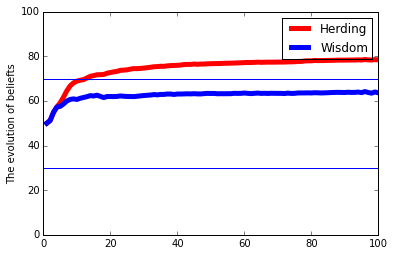

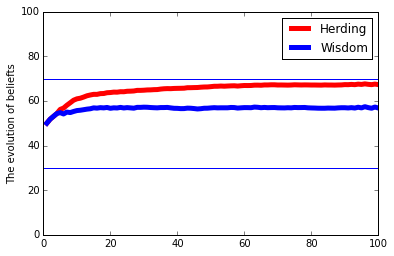

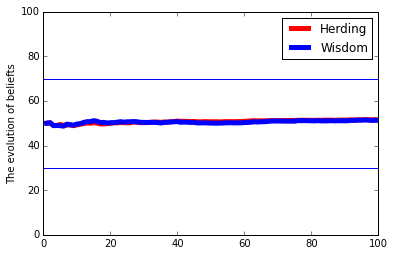

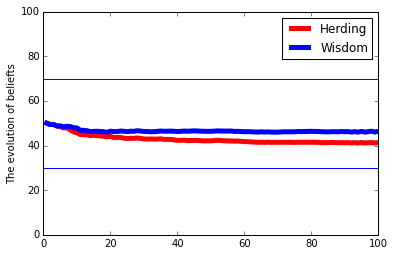

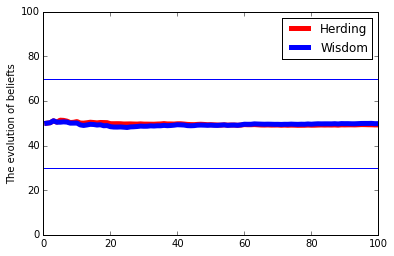

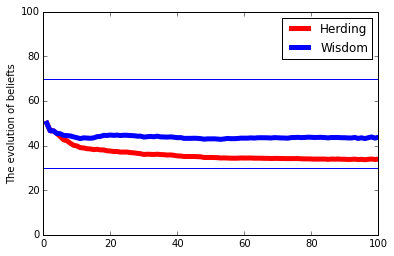

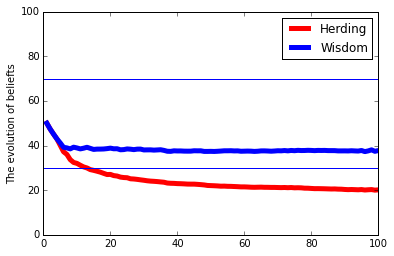

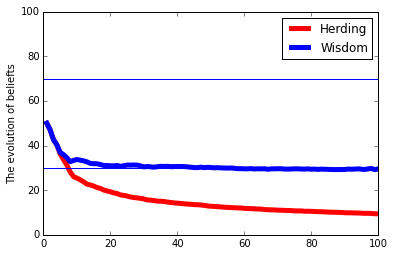

In [36]:
# change the threshold of quality & keep sd_left = 40 and sd_right = 10
# strong high-believers (possess superior signals of high type)
replicate_results(method={'private_belief_distribution': 'ushaped', 'mean_left': 0, 'sd_left': 40, 'mean_right': 0, 'sd_right': 10, 'initial_prior': 'normal'}, steps=100, threshold_quality=40, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'ushaped', 'mean_left': 0, 'sd_left': 40, 'mean_right': 0, 'sd_right': 10, 'initial_prior': 'normal'}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'ushaped', 'mean_left': 0, 'sd_left': 40, 'mean_right': 0, 'sd_right': 10, 'initial_prior': 'normal'}, steps=100, threshold_quality=60, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'ushaped', 'mean_left': 0, 'sd_left': 40, 'mean_right': 0, 'sd_right': 10, 'initial_prior': 'normal'}, steps=100, threshold_quality=70, gamma=50, sigma=20, repeat=100)

# change the threshold of quality & keep sd_left = 10 and sd_right = 40
# strong low-believers (possess superior signals of low-type)
replicate_results(method={'private_belief_distribution': 'ushaped', 'mean_left': 0, 'sd_left': 10, 'mean_right': 0, 'sd_right': 40, 'initial_prior': 'normal'}, steps=100, threshold_quality=40, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'ushaped', 'mean_left': 0, 'sd_left': 10, 'mean_right': 0, 'sd_right': 40, 'initial_prior': 'normal'}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'ushaped', 'mean_left': 0, 'sd_left': 10, 'mean_right': 0, 'sd_right': 40, 'initial_prior': 'normal'}, steps=100, threshold_quality=60, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'ushaped', 'mean_left': 0, 'sd_left': 10, 'mean_right': 0, 'sd_right': 40, 'initial_prior': 'normal'}, steps=100, threshold_quality=70, gamma=50, sigma=20, repeat=100)

#replicate_results(method={'private_belief_distribution': 'ushaped', 'mean_left': 0, 'sd_left': 10, 'mean_right': 0, 'sd_right': 40, 'initial_prior': 'itself'}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)


<h3 align="center"> ROBUSTNESS </h3> 

###### Results regarding normal priors and private beliefts are robust when using triangular distributions (only have one parameter (mode = peak of triangle with base from zero to 100).



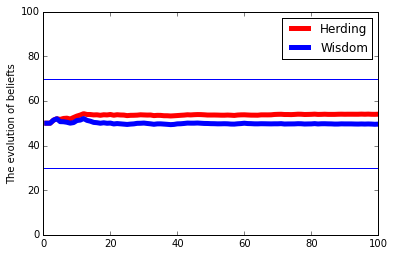

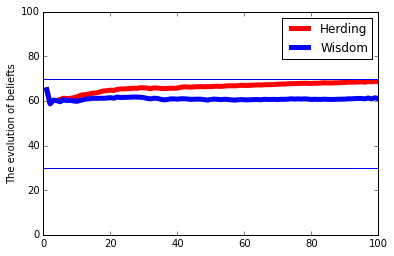

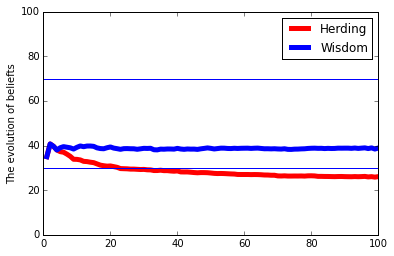

In [23]:
replicate_results(method={'private_belief_distribution': 'triangle', 'mode': 50.0}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'triangle', 'mode': 65.0}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
replicate_results(method={'private_belief_distribution': 'triangle', 'mode': 35.0}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)

